# Notebook de modelisation

In [116]:
!uv pip install scikit-learn numpy hdbscan

Using Python 3.11.6 environment at: c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5
Audited 3 packages in 15ms


In [117]:
import pandas as pd
import numpy as np
from sklearn import cluster, metrics, mixture
from sklearn.datasets import make_blobs
import time
import hdbscan  # Pour HDBSCAN
from joblib import Parallel, delayed

# Benchmark des models

Les modèles de clustering dispo avec [sklearn](https://scikit-learn.org/stable/modules/clustering.html) et son tableau comparatif

## Liste des algorithmes à comparer

In [118]:

n_cluster_value = 3
min_sample_value = 1000

model_list = {
    'kmeans': cluster.KMeans(n_clusters=n_cluster_value),
    'minibatchkmeans': cluster.MiniBatchKMeans(n_clusters=n_cluster_value),
    'hdbscan': hdbscan.HDBSCAN(min_cluster_size=min_sample_value),
    'gmm': mixture.GaussianMixture(n_components=n_cluster_value),
    'birch': cluster.Birch(n_clusters=n_cluster_value),
    'agglomerative': cluster.AgglomerativeClustering(n_clusters=n_cluster_value),
    'dbscan': cluster.DBSCAN(eps=0.5, min_samples=min_sample_value),
    'optics': cluster.OPTICS(min_samples=min_sample_value),
    'meanshift': cluster.MeanShift(),
}

## Benchmark RFM

In [119]:
# import des données
rfm = pd.read_excel('RFM.xlsx')
rfm = rfm.drop(['customer_unique_id', 'Segment'], axis=1).dropna()
rfm.head()

,Unnamed: 0,R,F,M
0,0,160,1,141.90
1,1,163,1,27.19
2,2,585,1,86.22
3,3,369,1,43.62
4,4,336,1,196.89


In [120]:
# On prend 10% des données pour gagner du temps d'execution
rfm_sample = rfm.sample(frac=0.1, random_state=42)
print(rfm_sample.shape)

(9610, 4)


### Fonction d'evaluation d'un modèle de clustering

In [121]:
def evaluate_algorithm(name, algorithm, data):
    start_time = time.time()

    # Fit et prédire les labels
    labels = algorithm.fit_predict(data)
    elapsed_time = time.time() - start_time

    # Calcul des scores
    silhouette_score = metrics.silhouette_score(data, labels) if len(set(labels)) > 1 else None
    davies_bouldin_score = metrics.davies_bouldin_score(data, labels) if len(set(labels)) > 1 else None
    calinski_harabasz_score = metrics.calinski_harabasz_score(data, labels) if len(set(labels)) > 1 else None

    return {
        "Algorithm": name,
        "Time (s)": elapsed_time,
        "Silhouette Score": silhouette_score,
        "Davies-Bouldin Score": davies_bouldin_score,
        "Calinski-Harabasz Score": calinski_harabasz_score
    }

### Entrainement des modèle (Utilisation du multithreading)

In [122]:
results = []

# Exécution en parallèle avec joblib
results = Parallel(n_jobs=-1)(delayed(evaluate_algorithm)(name, algorithm, rfm_sample)for name, algorithm in model_list.items())

# Création d'un DataFrame pour afficher les résultats
results_df = pd.DataFrame(results)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [ ]:
# Silhouette Score : Plus il est élevé, mieux c'est
# Davies-Bouldin Score : Plus il est faible, mieux c'est 
# Calinski-Harabasz Score : Plus il est élevé, mieux c'est

results_df.sort_values(by=['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score'], ascending=[False, True, False])

,Algorithm,Time (s),Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,kmeans,0.153502,0.593975,0.496598,38790.735804
4,birch,6.703001,0.593267,0.496833,38681.787083
5,agglomerative,10.911394,0.593267,0.496833,38681.787083
1,minibatchkmeans,0.165159,0.592974,0.496668,38353.877108
8,meanshift,133.754879,0.538532,0.503872,27050.627977
2,hdbscan,2.185456,0.268620,2.959296,3581.180627
3,gmm,0.275521,-0.000662,190.360082,0.174185
6,dbscan,0.143450,NaN,NaN,NaN
7,optics,22.201736,NaN,NaN,NaN


#### Find the best number of cluster (Plot metrics per number of cluster)

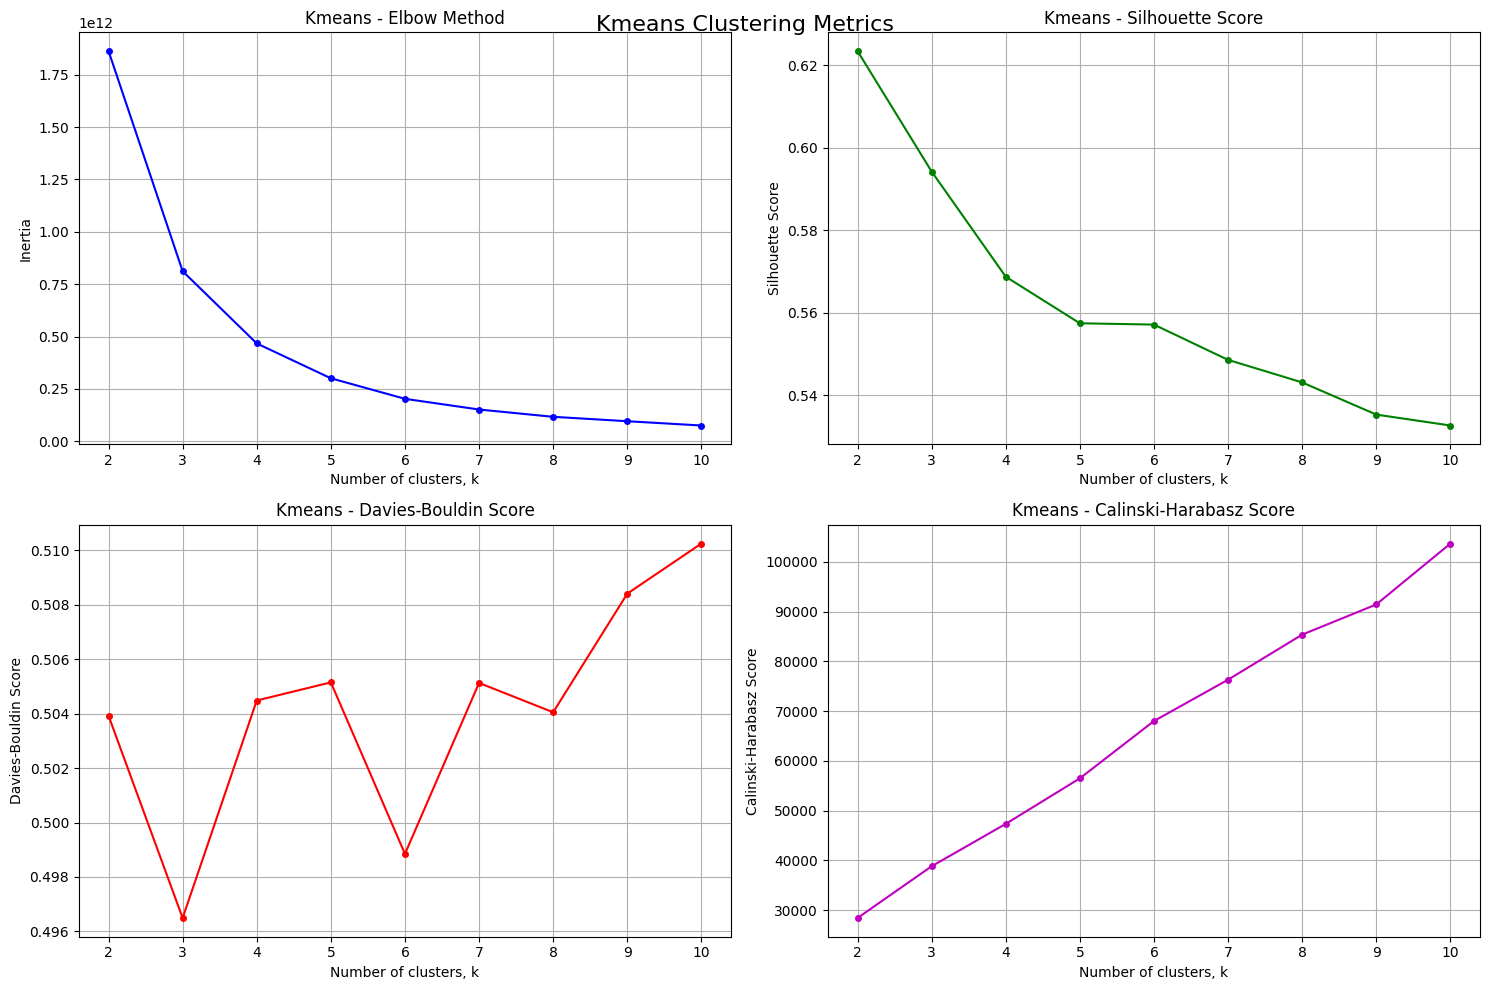

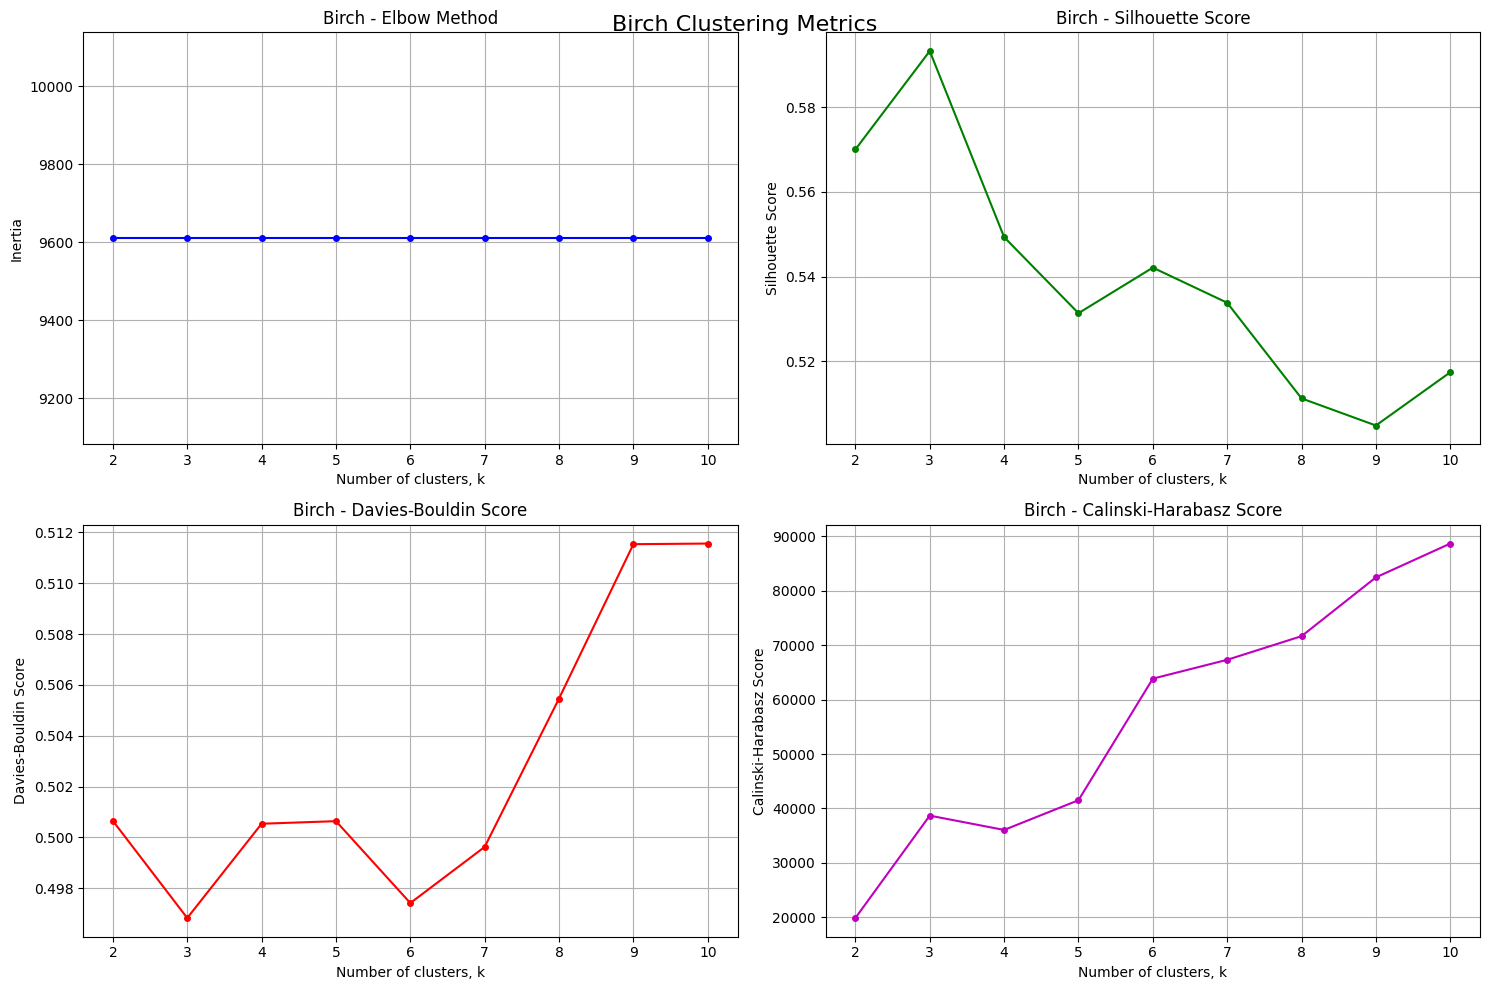

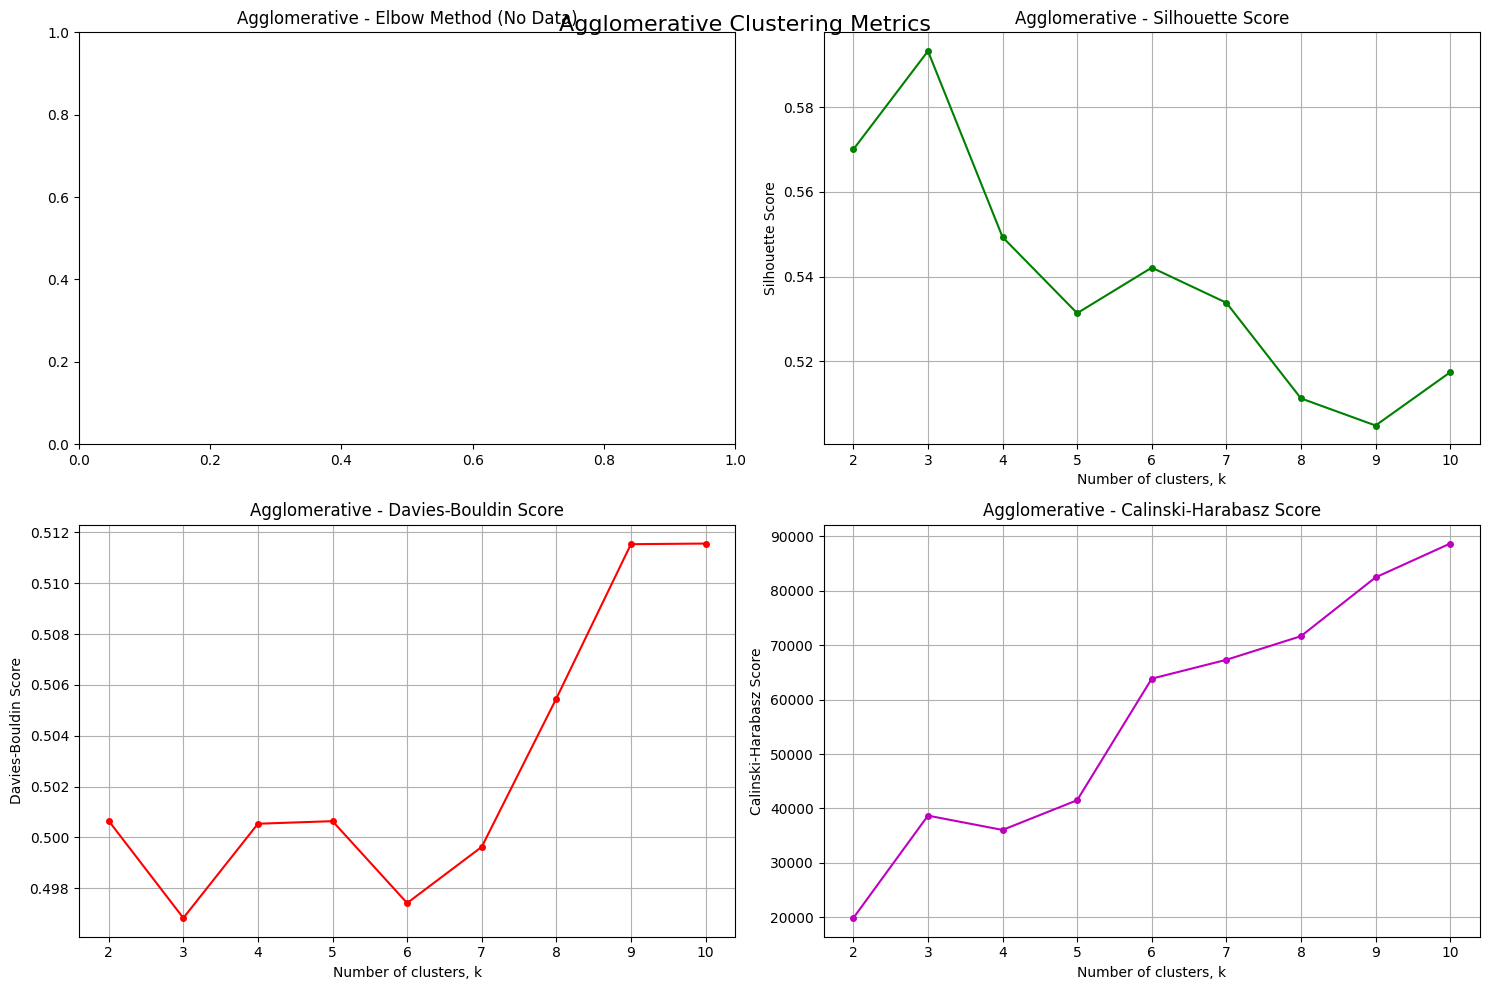

In [ ]:
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

def plot_metrics_for_each_model(data, max_k=10):
    metrics = {
        'kmeans': {'inertia': [], 'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []},
        'birch': {'inertia': [], 'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []},
        'agglomerative': {'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []},
    }

    k_values = range(2, max_k + 1)

    for k in k_values:
        # KMeans
        kmeans = cluster.KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        metrics['kmeans']['inertia'].append(kmeans.inertia_)
        if len(set(labels)) > 1:
            metrics['kmeans']['silhouette'].append(silhouette_score(data, labels))
            metrics['kmeans']['davies_bouldin'].append(davies_bouldin_score(data, labels))
            metrics['kmeans']['calinski_harabasz'].append(calinski_harabasz_score(data, labels))

        # Birch
        birch = cluster.Birch(n_clusters=k)
        labels = birch.fit_predict(data)
        if len(set(labels)) > 1:
            metrics['birch']['inertia'].append(birch.subcluster_centers_.shape[0])  # Approximation of inertia
            metrics['birch']['silhouette'].append(silhouette_score(data, labels))
            metrics['birch']['davies_bouldin'].append(davies_bouldin_score(data, labels))
            metrics['birch']['calinski_harabasz'].append(calinski_harabasz_score(data, labels))

        # Agglomerative Clustering
        agg = cluster.AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(data)
        if len(set(labels)) > 1:
            metrics['agglomerative']['silhouette'].append(silhouette_score(data, labels))
            metrics['agglomerative']['davies_bouldin'].append(davies_bouldin_score(data, labels))
            metrics['agglomerative']['calinski_harabasz'].append(calinski_harabasz_score(data, labels))

    # Tracé des métriques pour chaque modèle
    models = ['kmeans', 'birch', 'agglomerative']
    for model in models:
        plt.figure(figsize=(15, 10))

        # Elbow Method
        plt.subplot(2, 2, 1)
        if 'inertia' in metrics[model] and len(metrics[model]['inertia']) > 0:
            plt.plot(k_values, metrics[model]['inertia'], 'bo-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Inertia')
            plt.title(f'{model.capitalize()} - Elbow Method')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Elbow Method (No Data)')

        # Silhouette Score
        plt.subplot(2, 2, 2)
        if len(metrics[model]['silhouette']) > 0:
            plt.plot(k_values, metrics[model]['silhouette'], 'go-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Silhouette Score')
            plt.title(f'{model.capitalize()} - Silhouette Score')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Silhouette Score (No Data)')

        # Davies-Bouldin Score
        plt.subplot(2, 2, 3)
        if len(metrics[model]['davies_bouldin']) > 0:
            plt.plot(k_values, metrics[model]['davies_bouldin'], 'ro-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Davies-Bouldin Score')
            plt.title(f'{model.capitalize()} - Davies-Bouldin Score')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Davies-Bouldin Score (No Data)')

        # Calinski-Harabasz Score
        plt.subplot(2, 2, 4)
        if len(metrics[model]['calinski_harabasz']) > 0:
            plt.plot(k_values, metrics[model]['calinski_harabasz'], 'mo-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Calinski-Harabasz Score')
            plt.title(f'{model.capitalize()} - Calinski-Harabasz Score')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Calinski-Harabasz Score (No Data)')

        plt.tight_layout()
        plt.suptitle(f'{model.capitalize()} Clustering Metrics', fontsize=16)
        plt.show()

# Exemple d'utilisation avec des données fictives
# data = ... (votre jeu de données)
plot_metrics_for_each_model(rfm_sample)


Correspondance avec les sagments defini dans l'EDA
segment_order = ['Champions', 'Loyaux', 'Loyalistes potentiels', 'À réactiver', 'À risque', 'Perdus']

3 Correspond au 3 persona les plus presents et 6 correspond a tous les personas !

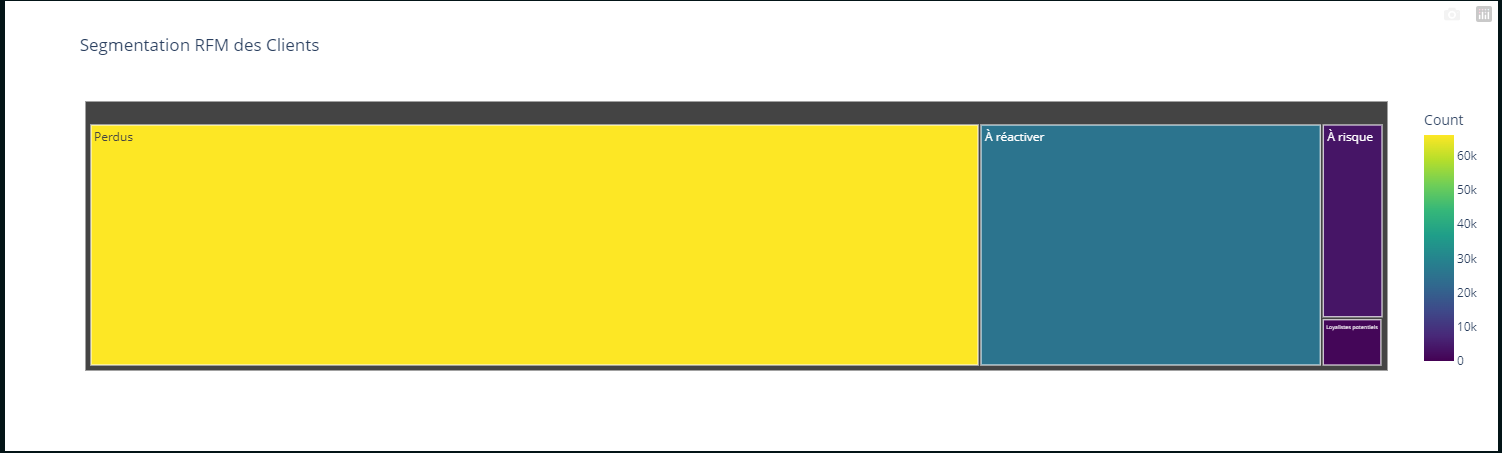

#### Calcul de l4ari

In [ ]:
rfm_segment = pd.read_excel('RFM.xlsx')

rfm_segment = rfm_segment[rfm_segment['Segment'].isin(['Perdus', 'À réactiver', 'À risque'])]
rfm_segment['Segment'].value_counts()

Segment
Perdus         66095
À réactiver    25413
À risque        3677
Name: count, dtype: int64

In [ ]:
rfm_segment_sample = rfm_segment.sample(frac=0.1, random_state=42)
rfm_segment_sample.shape

(9518, 6)

In [ ]:
rfm_segment_sample.reset_index()

,index,Unnamed: 0,customer_unique_id,R,F,M,Segment
0,64860,64860,ac8a18f289626f8da702418a4419bee9,92,1,47.86,À réactiver
1,46584,46584,7bd43abfde2d6a9a5c35da8749603fb3,268,1,179.84,Perdus
2,1428,1428,03cd0aecddfcc5c2d742df0db0103062,166,1,70.24,À réactiver
3,2804,2804,076dc8d838b4a277c14d6e67445b04bb,275,1,102.64,Perdus
4,50176,50176,85875ce411d496559611ed09ef65c177,177,1,106.50,À réactiver
...,...,...,...,...,...,...,...
9513,1300,1300,036ae786856e55298c63701d92a65b00,85,1,122.87,À réactiver
9514,3052,3052,080c8e3b883e668f0c1586f625ae83d6,275,1,37.77,Perdus
9515,90584,90584,f13d5dea2335435fe7c9b8a1901c1d1e,348,1,86.73,Perdus
9516,22852,22852,3cacfbd1c1e185f2798fcbe60b502fcb,496,1,137.08,Perdus


In [ ]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()

rfm_segment_sample['Segment'] = lb.fit_transform(rfm_segment_sample['Segment'])
rfm_segment_sample['Segment'].head()

64860    2
46584    0
1428     2
2804     0
50176    2
Name: Segment, dtype: int64

In [ ]:
rfm_segment_sample_predict = rfm_segment_sample.drop(['Segment', 'Unnamed: 0', 'customer_unique_id', 'index'], axis=1).reset_index()
rfm_segment_sample_predict

,index,R,F,M
0,64860,92,1,47.86
1,46584,268,1,179.84
2,1428,166,1,70.24
3,2804,275,1,102.64
4,50176,177,1,106.50
...,...,...,...,...
9513,1300,85,1,122.87
9514,3052,275,1,37.77
9515,90584,348,1,86.73
9516,22852,496,1,137.08


In [ ]:
from sklearn.metrics import adjusted_rand_score

# Exemple de labels de référence et de labels prédits
labels_pred = model_list['kmeans'].fit_predict(rfm_segment_sample_predict)

# Calcul de l'ARI
ari = adjusted_rand_score(labels_true, labels_pred)
print("Adjusted Rand Index:", ari)


Adjusted Rand Index: -0.00018138049360867677


#### Classification des clusters

#### Vue 2D

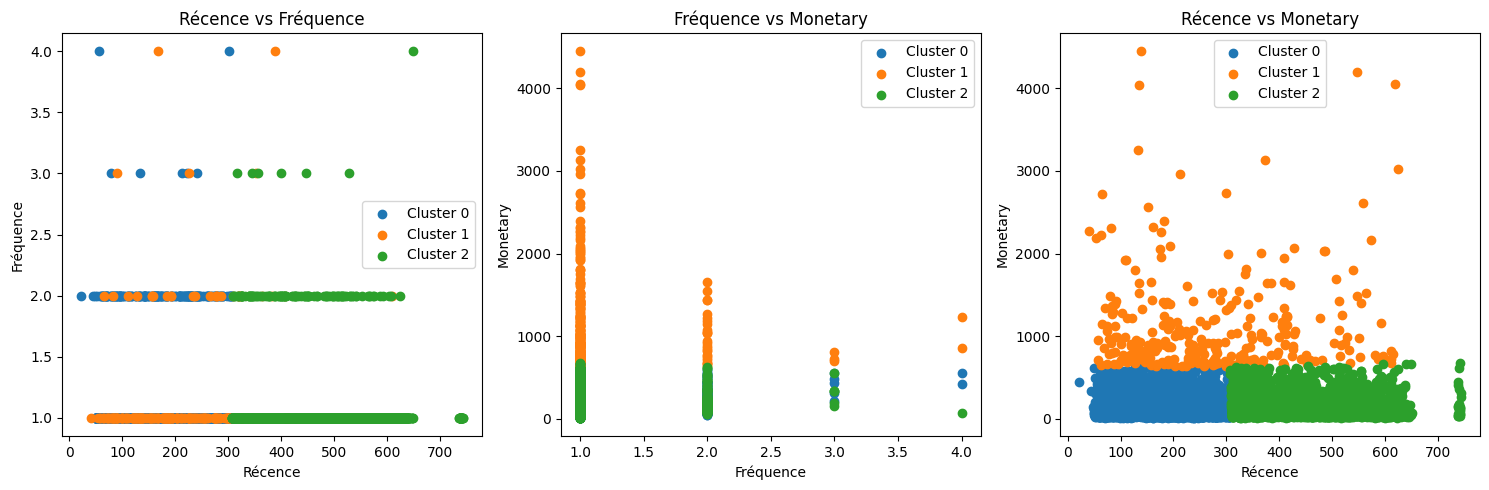

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Supposons que 'rfm_sample' est votre rfm_sampleFrame RFM
# rfm_sample = pd.rfm_sampleFrame(...)

# Appliquer KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
rfm_sample['Cluster'] = kmeans.fit_predict(rfm_sample[['R', 'F', 'M']])

# Analyser les centres des clusters
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['R', 'F', 'M'])
# print("Centres des clusters :")
# print(centers)

# Calculer les statistiques descriptives pour chaque cluster
cluster_stats = rfm_sample.groupby('Cluster')[['R', 'F', 'M']].agg(['mean', 'median', 'std'])
# print("Statistiques descriptives des clusters :")
# print(cluster_stats)

# Visualiser les clusters
plt.figure(figsize=(15, 5))

# Graphique Récence vs Fréquence
plt.subplot(1, 3, 1)
for cluster in range(3):
    plt.scatter(rfm_sample[rfm_sample['Cluster'] == cluster]['R'], rfm_sample[rfm_sample['Cluster'] == cluster]['F'], label=f'Cluster {cluster}')
plt.xlabel('Récence')
plt.ylabel('Fréquence')
plt.title('Récence vs Fréquence')
plt.legend()

# Graphique Fréquence vs Monetary
plt.subplot(1, 3, 2)
for cluster in range(3):
    plt.scatter(rfm_sample[rfm_sample['Cluster'] == cluster]['F'], rfm_sample[rfm_sample['Cluster'] == cluster]['M'], label=f'Cluster {cluster}')
plt.xlabel('Fréquence')
plt.ylabel('Monetary')
plt.title('Fréquence vs Monetary')
plt.legend()

# Graphique Récence vs Monetary
plt.subplot(1, 3, 3)
for cluster in range(3):
    plt.scatter(rfm_sample[rfm_sample['Cluster'] == cluster]['R'], rfm_sample[rfm_sample['Cluster'] == cluster]['M'], label=f'Cluster {cluster}')
plt.xlabel('Récence')
plt.ylabel('Monetary')
plt.title('Récence vs Monetary')
plt.legend()

plt.tight_layout()
plt.show()


#### Vue 3D

In [ ]:
import plotly.express as px
import pandas as pd

# Supposons que 'data' est votre DataFrame RFM avec une colonne 'Cluster'
# data = pd.DataFrame(...)

# Créer un graphique 3D avec Plotly
fig = px.scatter_3d(rfm_sample, x='R', y='F', z='M', color='Cluster',
                    labels={'R': 'Récence', 'F': 'Fréquence', 'M': 'Monetary', 'Cluster': 'Cluster'},
                    title='Clustering RFM en 3D')

# Afficher le graphique
fig.show()


## Benchmark RFMLS

In [ ]:
# import des données
rfmls = pd.read_excel('RFMLS.xlsx')
rfmls = rfmls.drop(['customer_unique_id', 'Unnamed: 0'], axis=1).dropna()
rfmls.head()

KeyboardInterrupt: 

In [ ]:
# On prend 10% des données pour gagner du temps d'execution
rfmls_sample = rfmls.sample(frac=0.1, random_state=42)
print(rfmls_sample.shape)

(9538, 5)


In [ ]:
import pandas as pd
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA

# Initialisation du FeatureHasher
hasher = FeatureHasher(n_features=50, input_type='string')

# Transformation de la colonne 'L' en une liste de listes
hashed_features = hasher.transform([[city] for city in rfmls_sample['L']])

# Initialisation du PCA
pca = PCA(n_components=1)  # Réduction à une seule dimension

# Application du PCA sur les caractéristiques hachées
hashed_features_pca = pca.fit_transform(hashed_features.toarray())

# Ajout de la composante principale au DataFrame original
rfmls_sample['L_pca'] = hashed_features_pca

print(rfmls_sample)


         R  F       M   S                   L     L_pca
72945  212  1  938.93   5           sao paulo -0.859466
572    460  1   43.91   5           silveiras  0.132610
73536  602  1  109.49   5           sao paulo -0.859466
40974  436  1   36.78   5         santo andre  0.139060
79128  145  1   49.32   5            rolandia  0.126389
...    ... ..     ...  ..                 ...       ...
8999    55  1  173.40   3           sao paulo -0.859466
94752  421  3  185.09  10  guaraguarabrasilia  0.125070
23072  125  1  108.72   5             pompeia  0.131797
33969  375  1  285.78   5     duque de caxias  0.289153
504    215  1   96.87   3           sao paulo -0.859466

[9538 rows x 6 columns]


### Entrainement des modèle (Utilisation du multithreading)

In [ ]:
rfmls_sample_train = rfmls_sample.drop('L', axis=1)

In [ ]:
results = []

# Exécution en parallèle avec joblib
results = Parallel(n_jobs=-1)(delayed(evaluate_algorithm)(name, algorithm, rfmls_sample_train)for name, algorithm in model_list.items())

# Création d'un DataFrame pour afficher les résultats
results_df = pd.DataFrame(results)

In [ ]:
# Silhouette Score : Plus il est élevé, mieux c'est
# Davies-Bouldin Score : Plus il est faible, mieux c'est 
# Calinski-Harabasz Score : Plus il est élevé, mieux c'est

results_df.sort_values(by=['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score'], ascending=[False, True, False])

,Algorithm,Time (s),Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
8,meanshift,110.907758,0.633797,0.502505,955.049796
4,birch,12.166445,0.457629,0.928762,4843.030665
1,minibatchkmeans,0.054664,0.441535,0.785812,5787.586860
0,kmeans,0.019423,0.424045,0.801581,6622.623109
5,agglomerative,9.517272,0.390427,0.733622,4970.038671
3,gmm,0.884530,0.026672,4.754962,877.930827
2,hdbscan,3.401908,NaN,NaN,NaN
6,dbscan,0.500778,NaN,NaN,NaN
7,optics,25.405664,NaN,NaN,NaN


#### Find the best number of cluster (Plot metrics per number of cluster)

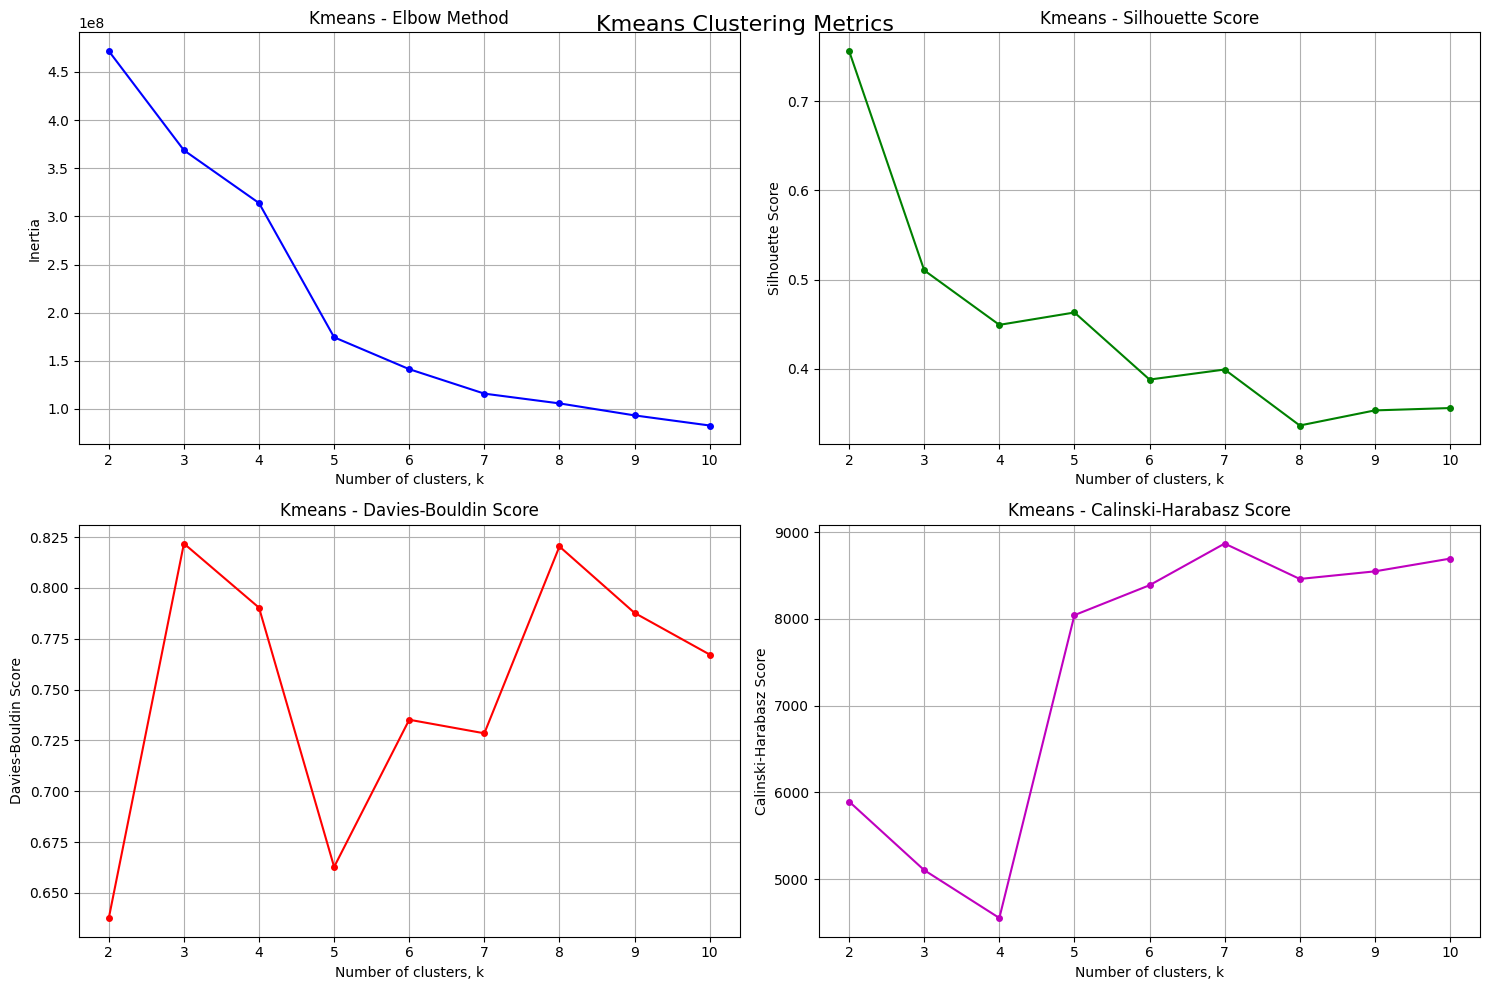

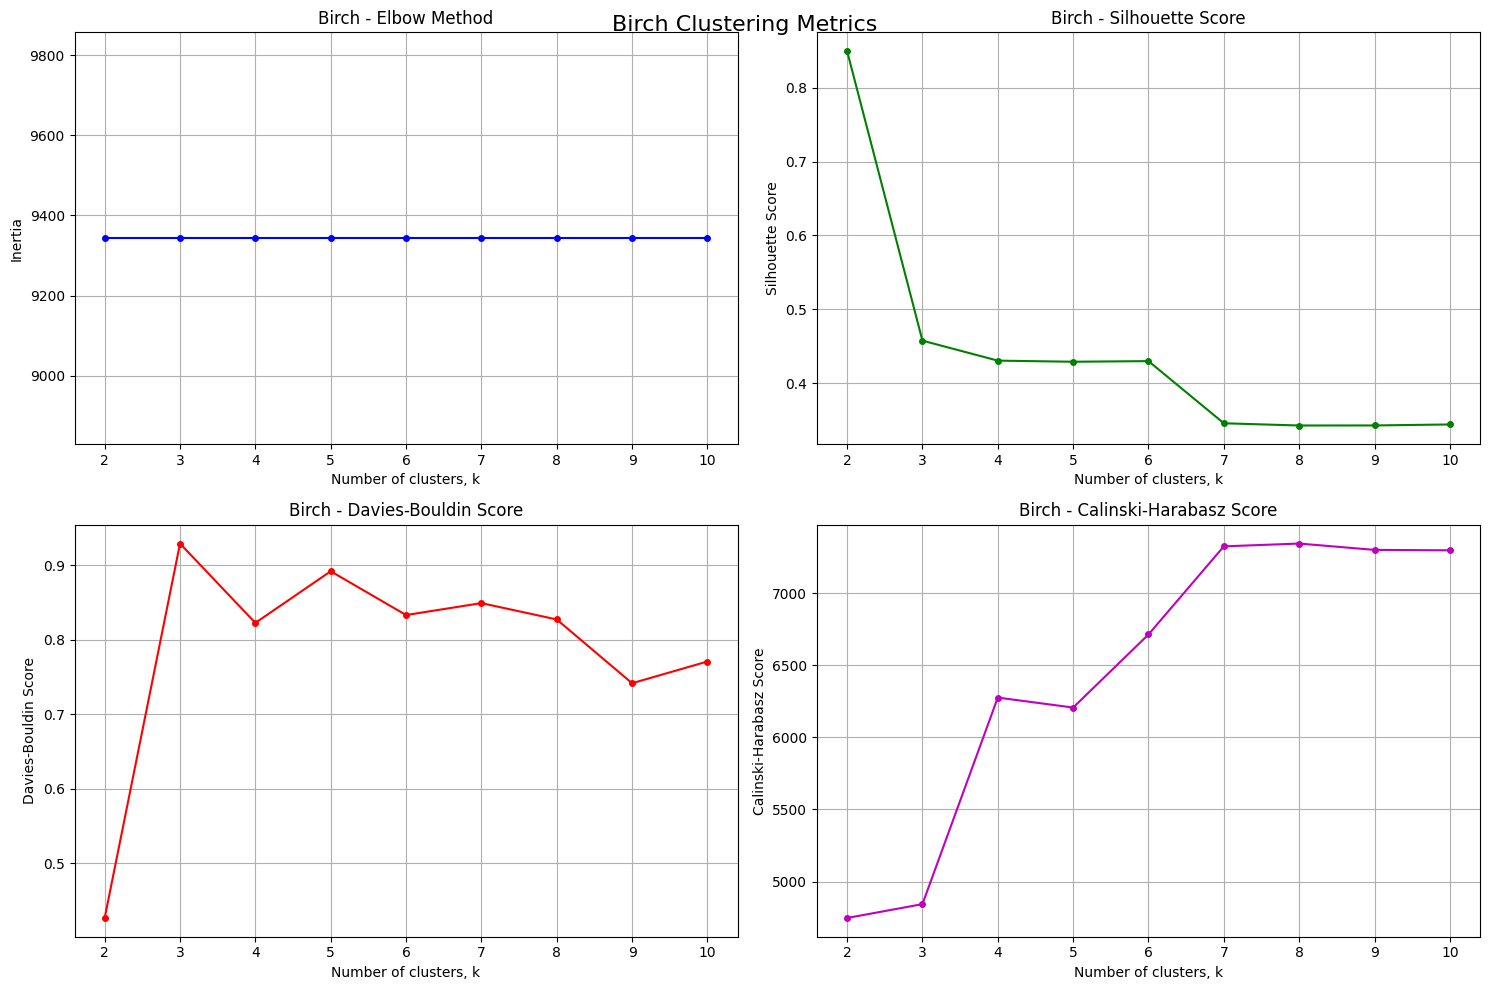

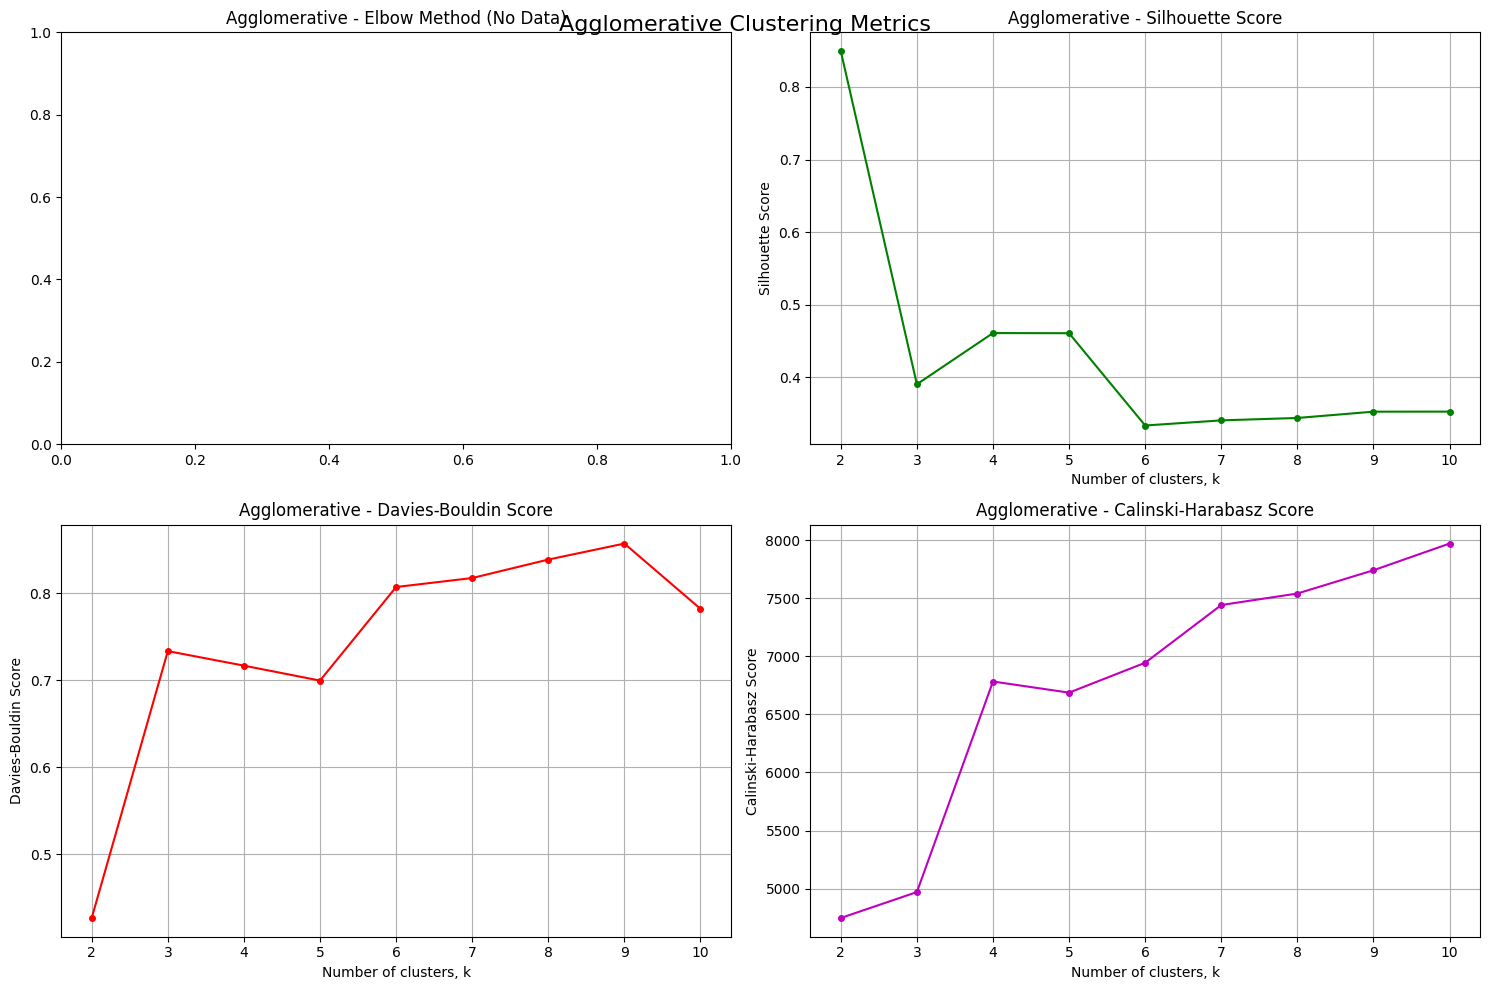

In [ ]:
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

def plot_metrics_for_each_model(data, max_k=10):
    metrics = {
        'kmeans': {'inertia': [], 'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []},
        'birch': {'inertia': [], 'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []},
        'agglomerative': {'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []},
    }

    k_values = range(2, max_k + 1)

    for k in k_values:
        # KMeans
        kmeans = cluster.KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        metrics['kmeans']['inertia'].append(kmeans.inertia_)
        if len(set(labels)) > 1:
            metrics['kmeans']['silhouette'].append(silhouette_score(data, labels))
            metrics['kmeans']['davies_bouldin'].append(davies_bouldin_score(data, labels))
            metrics['kmeans']['calinski_harabasz'].append(calinski_harabasz_score(data, labels))

        # Birch
        birch = cluster.Birch(n_clusters=k)
        labels = birch.fit_predict(data)
        if len(set(labels)) > 1:
            metrics['birch']['inertia'].append(birch.subcluster_centers_.shape[0])  # Approximation of inertia
            metrics['birch']['silhouette'].append(silhouette_score(data, labels))
            metrics['birch']['davies_bouldin'].append(davies_bouldin_score(data, labels))
            metrics['birch']['calinski_harabasz'].append(calinski_harabasz_score(data, labels))

        # Agglomerative Clustering
        agg = cluster.AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(data)
        if len(set(labels)) > 1:
            metrics['agglomerative']['silhouette'].append(silhouette_score(data, labels))
            metrics['agglomerative']['davies_bouldin'].append(davies_bouldin_score(data, labels))
            metrics['agglomerative']['calinski_harabasz'].append(calinski_harabasz_score(data, labels))

    # Tracé des métriques pour chaque modèle
    models = ['kmeans', 'birch', 'agglomerative']
    for model in models:
        plt.figure(figsize=(15, 10))

        # Elbow Method
        plt.subplot(2, 2, 1)
        if 'inertia' in metrics[model] and len(metrics[model]['inertia']) > 0:
            plt.plot(k_values, metrics[model]['inertia'], 'bo-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Inertia')
            plt.title(f'{model.capitalize()} - Elbow Method')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Elbow Method (No Data)')

        # Silhouette Score
        plt.subplot(2, 2, 2)
        if len(metrics[model]['silhouette']) > 0:
            plt.plot(k_values, metrics[model]['silhouette'], 'go-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Silhouette Score')
            plt.title(f'{model.capitalize()} - Silhouette Score')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Silhouette Score (No Data)')

        # Davies-Bouldin Score
        plt.subplot(2, 2, 3)
        if len(metrics[model]['davies_bouldin']) > 0:
            plt.plot(k_values, metrics[model]['davies_bouldin'], 'ro-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Davies-Bouldin Score')
            plt.title(f'{model.capitalize()} - Davies-Bouldin Score')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Davies-Bouldin Score (No Data)')

        # Calinski-Harabasz Score
        plt.subplot(2, 2, 4)
        if len(metrics[model]['calinski_harabasz']) > 0:
            plt.plot(k_values, metrics[model]['calinski_harabasz'], 'mo-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Calinski-Harabasz Score')
            plt.title(f'{model.capitalize()} - Calinski-Harabasz Score')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Calinski-Harabasz Score (No Data)')

        plt.tight_layout()
        plt.suptitle(f'{model.capitalize()} Clustering Metrics', fontsize=16)
        plt.show()

# Exemple d'utilisation avec des données fictives
# data = ... (votre jeu de données)
plot_metrics_for_each_model(rfmls_sample_train)


Correspondance avec les sagments defini dans l'EDA
segment_order = ['Champions', 'Loyaux', 'Loyalistes potentiels', 'À réactiver', 'À risque', 'Perdus']

3 Correspond au 3 persona les plus presents et 6 correspond a tous les personas !

![{A84F2560-6E5B-4FE6-8987-0BEFCC5E62EC}.png](attachment:{A84F2560-6E5B-4FE6-8987-0BEFCC5E62EC}.png)

#### Classification des clusters

#### Vue 2D

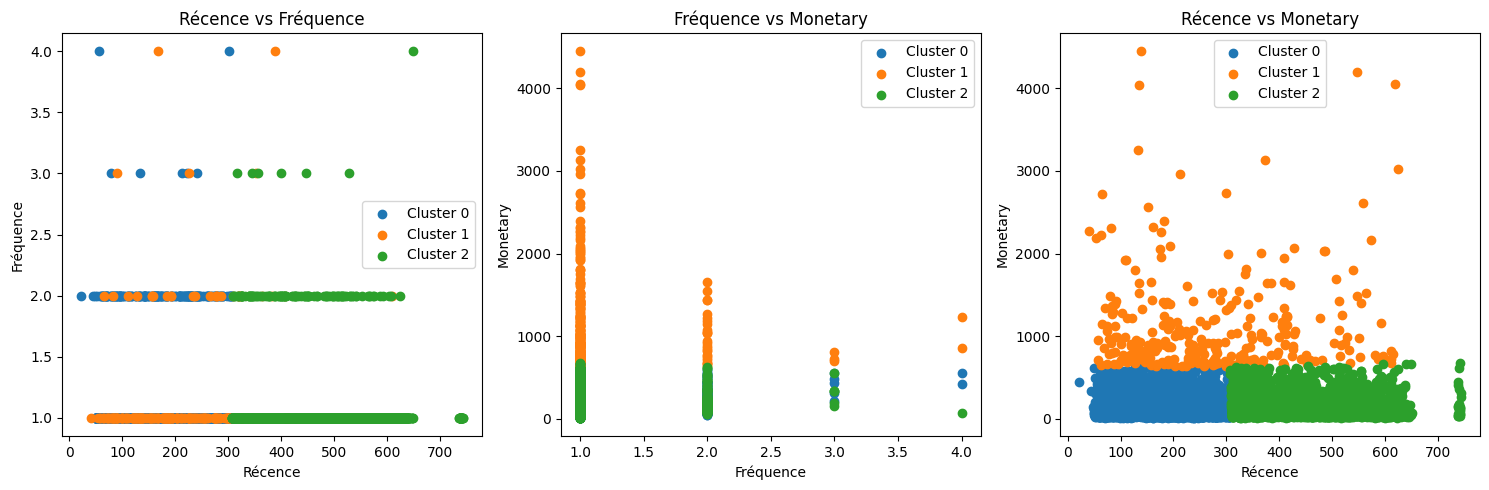

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Appliquer KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
rfmls_sample['Cluster'] = kmeans.fit_predict(rfmls_sample[['R', 'F', 'M']])

# Analyser les centres des clusters
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['R', 'F', 'M'])
# print("Centres des clusters :")
# print(centers)

# Calculer les statistiques descriptives pour chaque cluster
cluster_stats = rfmls_sample.groupby('Cluster')[['R', 'F', 'M']].agg(['mean', 'median', 'std'])
# print("Statistiques descriptives des clusters :")
# print(cluster_stats)

# Visualiser les clusters
plt.figure(figsize=(15, 5))

# Graphique Récence vs Fréquence
plt.subplot(1, 3, 1)
for cluster in range(3):
    plt.scatter(rfmls_sample[rfmls_sample['Cluster'] == cluster]['R'], rfmls_sample[rfmls_sample['Cluster'] == cluster]['F'], label=f'Cluster {cluster}')
plt.xlabel('Récence')
plt.ylabel('Fréquence')
plt.title('Récence vs Fréquence')
plt.legend()

# Graphique Fréquence vs Monetary
plt.subplot(1, 3, 2)
for cluster in range(3):
    plt.scatter(rfmls_sample[rfmls_sample['Cluster'] == cluster]['F'], rfmls_sample[rfmls_sample['Cluster'] == cluster]['M'], label=f'Cluster {cluster}')
plt.xlabel('Fréquence')
plt.ylabel('Monetary')
plt.title('Fréquence vs Monetary')
plt.legend()

# Graphique Récence vs Monetary
plt.subplot(1, 3, 3)
for cluster in range(3):
    plt.scatter(rfmls_sample[rfmls_sample['Cluster'] == cluster]['R'], rfmls_sample[rfmls_sample['Cluster'] == cluster]['M'], label=f'Cluster {cluster}')
plt.xlabel('Récence')
plt.ylabel('Monetary')
plt.title('Récence vs Monetary')
plt.legend()

plt.tight_layout()
plt.show()


#### Vue 3D

In [ ]:
import plotly.express as px
import pandas as pd

# Supposons que 'data' est votre DataFrame RFM avec une colonne 'Cluster'
# data = pd.DataFrame(...)

# Créer un graphique 3D avec Plotly
fig = px.scatter_3d(rfmls_sample, x='R', y='F', z='M', color='Cluster',
                    labels={'R': 'Récence', 'F': 'Fréquence', 'M': 'Monetary', 'Cluster': 'Cluster'},
                    title='Clustering RFM en 3D')

# Afficher le graphique
fig.show()


#### Entrainement & enregistrement du modèle

In [ ]:
model_list['kmeans']

KMeans(n_clusters=6)